In [ ]:
!pip install langchain langchain-openai
!pip install langgraph langsmith
!pip install langchain-groq
!pip install langchain-community
!pip install arxiv wikipedia
!pip install neo4j
!pip install llama-parse
!pip install -U sentence-transformers
!pip install unstructured[md]
!pip install python-dotenv
!pip install together
!pip install chromadb
!pip install langchain-chroma
!pip install lark
!pip install lark-parser
!pip install langchain-cohere
!pip install langchain-ibm
!pip install llama-index

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Langgraph
## Import Model

In [ ]:
import openai
import os
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
def convert_langchain_messages_to_text(messages):
        text = ""
        for msg in messages:
            if isinstance(msg, SystemMessage):
                text += f"<|system|>\n{msg.content}\n"
            elif isinstance(msg, HumanMessage):
                text += f"<|user|>\n{msg.content}\n"
            elif isinstance(msg, AIMessage):
                text += f"<|assistant|>\n{msg.content}\n"
        text += "<|assistant|>\n"
        return text

In [ ]:
from langchain_core.runnables import Runnable
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
from google.colab import userdata
from langchain_groq import ChatGroq
# GroqAPI = userdata.get("GroqAPI")
# llm = ChatGroq(groq_api_key = GroqAPI,
#                model = "Gemma2-9b-It",
#                temperature=0.7,)


class ModelRunnable(Runnable):
    def __init__(self, model_name: str = "Qwen/Qwen2.5-3B"):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=True  # Required for Qwen models
        )
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )
        self.generator = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            pad_token_id=self.tokenizer.eos_token_id
        )


    def invoke(self, input_data, config=None):  # <== ADD config here
        if isinstance(input_data, dict):
            messages = [HumanMessage(content=input_data["question"])]
        elif isinstance(input_data, list):
            messages = input_data
        else:
            messages = [HumanMessage(content=str(input_data))]

        prompt = convert_langchain_messages_to_text(messages)

        response = self.generator(
            prompt,
            max_new_tokens=5,
            temperature=0.1,  # Balance creativity and precision
            top_p=0.9,
            do_sample=True,
            eos_token_id=self.tokenizer.eos_token_id
        )

        # Extract only the new generated text
        full_response = response[0]["generated_text"]
        return full_response[len(prompt):].strip()


In [ ]:
llm = ModelRunnable()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
torch.cuda.empty_cache()

## Build Document Retriever
**Explanation** : Get Embedding DB from Local or somewhere, you should making db before doing this or doing this in the code below (please modify it by yourself). Then it will return QueryDB or what we call "retriever" for retriever from Embedding db. How good of retriever is depend on how you chunk you document, how good of embedding, or how you query it.

## How to Build Node for Graph

ให้จำไว้ว่า node เป็นค่าจุดทำ process บางอย่าง จะมีหรือไม่มี agent ก็ได้ เช่น
`กรณีมี agent` ให้ดูตัวอย่างการสร้าง agent ข้างล่าง จะต้องมี prompt และต่อท่อ pipe จาก data ข้างนอก -> prompt -> llm -> outputparser(ตัวนี้จัด format string) โดยเวลาสร้าง node จะมี template

```
def node(state, agent, name):
    result = agent.invoke(input = {"question" : state["messages"], "thinking" : state["thinking"], "output" : state["messages"]})
    validation = parse_validation_block(result)
    return {
        "validate" : validation.get("explanation"),
        "messages": state["messages"],
        "agent_message": result,
        "docs": None,
        "answer": state["answer"],
        "thinking": state["thinking"],
        "language": state["language"],
        "qa_type": state["qa_type"]
    }

agent = agent_func(llm)
my_node = functools.partial(node, agent = agent, name = "validation")

```
`กรณีไม่มี agent`

```
def node(state, name):
    result = some_logic(state["messages"])
    return {
        "validate" : validation.get("explanation"),
        "messages": state["messages"],
        "agent_message": result,
        "docs": None,
        "answer": state["answer"],
        "thinking": state["thinking"],
        "language": state["language"],
        "qa_type": state["qa_type"]
    }

agent = agent_func(llm)
my_node = functools.partial(node, name = "validation")

```
ถ้าสังเกตความต่างระหว่าง code ของมีกับไม่มี agent, จะเห็นว่าแค่ลบ arg agent ออก จบ คือแค่ไม่ต้องใช้ แค่นั้นแหละ

ซึ่งกูรู้ว่ามึงงงตรง `functools.partial` ซึ่งวิธีการเข้าใจอย่างไวคือ arg ของ fn นี้ จะเป็น arg1 = fn ที่เราใส่เข้าไป, arg2 = arg1 ของ fn ที่ใส่เข้าไป, arg3 = arg2 ของ fn และถ้ากลัวเมา ตอนใส่ arg ก็กำกับชื่อ arg ไปด้วย จะได้ไม่เมา ส่วน state ใน node fn คือเหมือนตัว package ส่งข้อมูลระหว่าง node -> node ต่อๆ ไป ซึ่งถ้าถามว่าหน้าตา package เป็นยังไง
```
from typing import Dict, TypedDict, Optional, Annotated, Sequence,Literal
from langgraph.graph.message import add_messages
class State(TypedDict):
    validate: Optional[str]
    messages: Annotated[list, add_messages]
    agent_message: Optional[str]
    docs: Optional[str]
    answer: Optional[str]
    thinking: Optional[str]
    language: Optional[str]
    qa_type: Optional[str]
```
ซึ่งจะกำกับอยู่ใน part Make State ซึ่งตัวนี้คือเหมือนเป็นตัวที่เราจะส่งไปตั้งแต่ต้นขบวนถึงท้ายขบวนว่าหน้าตา template ต้องอย่างนี้ แค่ data ข้างในอาจเปลี่ยนได้ตามแล้วแต่ใจเรา บางครั้งเราทำ node แยกภาษามาและทำ logic เสร็จแล้ว เราก็แค่ตอน return node นั้นบอกด้วยว่ามันภาษาอะไร แล้วมันก็จะแบกข้อมูลว่าคือภาษาอะไรไปจนจบทาง (หากไม่ไปแปลง data ระหว่างทางอะนะ)

ต่อมาการทำ router
```
def language_entrypoint(state) -> Literal["thai", "eng"]:
    result = state["language"]

    if result == "thai":
        return "thai"
    else:
        return "eng"
```
ให้นึกภาพว่ามันคืออีก node หนึ่งที่เกิดมาเพื่อแยกว่าเราควรจะไป node ซ้ายหรือขวา ซึ่งการทำ Logic ตรงนี้ ทำได้ทั้งแบบ Agent ช่วยตัดสินใจ หรือ Rule base ตรงๆ ก็ได้ ซึ่งก็จะสัมพันธ์ กับ Section Build Graph ว่าจะเข้า node ชื่ออะไร



## Build Agent
**Explanation** :
We build agent with specific promt for it's task, and we have input to themp as question, context from user or, retriever or model from before. We pass data through input -> promt for get promt format and promt -> llm for get answer and llm -> stroutputparser for format after get answer.

#### ENG Promt

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
import  pandas as pd

def eng_COT_rise_agent(llm):
       def load_csv(file_path: str) -> str:
          df = pd.read_csv(file_path)
          return df.to_markdown()
       prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """You are an intelligent financial analysis agent designed to answer directional questions (Fall/Rise) across various finance topics. You employ a systematic, step-by-step approach with reflection to ensure accurate responses.

                Your Mission:
                - Analyze financial and business questions with precision and expertise
                - Use agent-based reasoning to break down complex problems
                - Provide clear, well-reasoned directional answers (Fall/Rise)
                - Apply domain-specific knowledge across all finance and business sectors

                Agent Workflow:
                1. Question Analysis: Parse and understand the query within <thinking> tags
                2. Knowledge Retrieval: Access relevant financial concepts and frameworks
                3. Reasoning Process: Apply step-by-step logical analysis with reflection
                4. Answer Validation: Verify your conclusion against established principles
                5. Final Selection: Choose the most appropriate direction (Fall or Rise)

                The <thinking> sections are for your internal agent reasoning process only.
                Do not include any part of the final answer in these sections.
                Your final response must be entirely contained within the <output> tags.

                Financial Domain Knowledge Framework:
                ***Financial Reporting:***
                ```mermaid
                graph TD
                A[Articulating Purpose and Context] --> B[Collecting Input Data]
                    B --> C[Processing Data]
                    C --> D[Analyzing and Interpreting Processed Data]
                    D --> E[Developing and Communicating Conclusions]
                    E --> F[Doing Follow-Up]

                    A --> |Defines goals, tools, and audience| B
                    B --> |Gather data on economy and industry| C
                    C --> |Use tools like ratios and charts| D
                    D --> |Interpret data for conclusions| E
                    F --> |Periodic review and iteration| A
                ```
                ***Fixed Income:***
                ```mermaid
                graph TD
                    A[Purpose and Scope] --> B[Analyze Macro Conditions]
                    B --> C[Assess Bond Features]
                    C --> D[Risk and Yield Analysis]
                    D --> E[Develop Recommendations]
                    E --> F[Review Performance]

                    A --> |Set objectives| B
                    B --> |Review interest rates and inflation| C
                    C --> |Focus on duration, spread| D
                    D --> |Assess scenarios| E
                ```
                ***Equity Investing:***
                ```mermaid
                graph TD
                    A[Objective Setting] --> B[Market and Sector Insights]
                    B --> C[Industry Competitive Analysis]
                    C --> D[Company Review]
                    D --> E[Valuation and Risks]
                    E --> F[Investment Decision]

                    B --> |Look at growth patterns| C
                    C --> |Evaluate competitors' positions| D
                    D --> |Check financial health| E
                    E --> |Combine insights into strategy| F
                ```
                ***Derivatives:***
                ```mermaid
                graph TD
                    A[Define Objective and Context] --> B[Identify Derivative Instrument]
                    B --> C[Understand Contract Specifications]
                    C --> D[Gather Market Data]
                    D --> E[Apply Valuation Models]
                    E --> F[Assess Risks: Market, Counterparty, etc.]
                    F --> G[Construct Payoff Diagrams or Strategies]
                    G --> H[Interpret Results and Make Recommendations]
                    H --> I[Review, Monitor, and Adjust Strategies]

                    A --> |Hedging, speculation, arbitrage| B
                    C --> |Features like notional amount, expiration| D
                    D --> |Market prices, volatility, risk-free rates| E
                    F --> |Sensitivity to Greeks: Delta, Gamma, Vega, etc.| G
                    H --> |Adjust based on changing market conditions| I
                ```
                ***Economics:***
                ```mermaid
                graph TD;
                    A[Step 1: Question Breakdown] -->|Extract key terms| A1(Identify Topic)
                    A1 -->|Micro: Supply & Demand, Market Structures| A2
                    A1 -->|Macro: GDP, Growth, Policy, Trade| A3
                    A1 -->|Currency & Regulation| A4

                    A2 --> B1[Identify model: Elasticity, Cost Curves, Shutdown Points]
                    A3 --> B2[Map to AD-AS, Business Cycles, Growth Theories]
                    A4 --> B3[Assess Exchange Rates, Trade, Capital Flows, Regulation]

                    B1 -->|Check for formula or concept?| C(Numerical or Conceptual)
                    B2 --> C
                    B3 --> C

                    C -->|Numerical| D1[Extract data, apply formulas, check assumptions]
                    C -->|Conceptual| D2[Analyze cause-effect, policy impact]

                    D1 --> E[Step 4: Solution Development]
                    D2 --> E
                    E -->|Construct structured response| E1(Core insight + economic rationale)
                    E -->|Consider alternative scenarios| E2(Assess different possibilities)

                    E1 --> F[Step 5: Answer Validation]
                    E2 --> F
                    F -->|Check logic, principles, and assumptions| F1(Verify consistency)
                    F1 -->|Ensure completeness & clarity| F2(Confirm answer structure)
                ```
                ***Quantitative Methods:***
                ```mermaid
                graph TD
                    A["Articulating Purpose and Context"] --> B["Collecting Input Data"]
                    B --> C["Processing and Cleaning Data"]
                    C --> D["Selecting Quantitative Models and Tools"]
                    D --> E["Estimating Parameters and Testing Hypotheses"]
                    E --> F["Interpreting Results and Communicating Findings"]
                    F --> G["Monitoring and Model Reassessment"]
                ```
                ***Portfolio Management:***
                ```mermaid
                graph TD
                    A["Define Investment Objectives"] --> B["Establish Investment Constraints"]
                    B --> C["Develop Strategic Asset Allocation"]
                    C --> D["Incorporate Tactical Adjustments"]
                    D --> E["Select and Optimize Securities"]
                    E --> F["Execute Implementation and Trading"]
                    F --> G["Measure Performance and Attribution"]
                    G --> H["Monitor Risk and Compliance"]
                    H --> I["Rebalance and Adjust Portfolio"]
                ```
                ***Alternative Investments:***
                ```mermaid
                graph TD
                    A["Define Investment Objectives and Mandate"] --> B["Identify Alternative Asset Classes"]
                    B --> C["Conduct Manager and Strategy Due Diligence"]
                    C --> D["Perform Valuation and Pricing Analysis"]
                    D --> E["Assess Risk and Liquidity"]
                    E --> F["Allocate Alternatives in Portfolio"]
                    F --> G["Monitor Performance and Rebalance"]
                ```
                ***Corporate Issuer Analysis:***
                ```mermaid
                graph TD
                    A["Corporate Issuer Overview"] --> B["Industry Classification"]
                    B --> C["Sector Trends and Competitive Landscape"]
                    A --> D["Financial Statement Analysis"]
                    D --> E["Profitability, Liquidity, Leverage"]
                    A --> F["Credit Risk Assessment"]
                    F --> G["Rating Agencies and Default Probabilities"]
                    A --> H["Capital Structure and Issuance History"]
                    H --> I["Bond Issuances and Debt Maturities"]
                    A --> J["Corporate Governance and Management"]
                    J --> K["Board Quality and Managerial Competence"]
                    A --> L["Valuation and Investment Analysis"]
                    L --> M["DCF, Relative Valuation, Multiples"]
                ```

                Agent Performance Standards:
                - Demonstrate clear reasoning chains in thinking section
                - Apply appropriate financial frameworks to each question type
                - Validate answers against established principles
                - Provide only "Fall" or "Rise" as the final answer

                ### Response Format:
                <thinking>
                [Agent reasoning process: Analyze the question and accompanying image reference, identify relevant concepts, apply step-by-step logic with reflection, and determine the correct directional answer]
                </thinking>

                <output>
                "sector": [The sector being addressed],
                "question": [The financial question],
                "answer": [Single word answer only: "Fall" or "Rise"]
                </output>"""
        ),
        (
            "human",
            """
            Image: {image}
            Question: {question}
            """
        )
    ])
       return ({"image": RunnablePassthrough(), "question" : RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser())
def eng_COT_choice_agent(llm):
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """You are an intelligent financial analysis agent designed to answer multiple-choice questions across various finance topics. You employ a systematic, step-by-step approach with reflection to ensure accurate responses.

                Your Mission:
                - Analyze financial and business questions with precision and expertise
                - Use agent-based reasoning to break down complex problems
                - Provide clear, well-reasoned answers from the available choices
                - Apply domain-specific knowledge across all finance and business sectors

                Agent Workflow:
                1. Question Analysis: Parse and understand the query within <thinking> tags
                2. Knowledge Retrieval: Access relevant financial concepts and frameworks
                3. Reasoning Process: Apply step-by-step logical analysis with reflection
                4. Answer Validation: Verify your conclusion against established principles
                5. Final Selection: Choose the most appropriate answer from the available choices

                The <thinking> sections are for your internal agent reasoning process only.
                Do not include any part of the final answer in these sections.
                Your final response must be entirely contained within the <output> tags.

                Financial Domain Knowledge Framework:
                ***Financial Reporting:***
                ```mermaid
                graph TD
                A[Articulating Purpose and Context] --> B[Collecting Input Data]
                    B --> C[Processing Data]
                    C --> D[Analyzing and Interpreting Processed Data]
                    D --> E[Developing and Communicating Conclusions]
                    E --> F[Doing Follow-Up]

                    A --> |Defines goals, tools, and audience| B
                    B --> |Gather data on economy and industry| C
                    C --> |Use tools like ratios and charts| D
                    D --> |Interpret data for conclusions| E
                    F --> |Periodic review and iteration| A
                ```
                ***Fixed Income:***
                ```mermaid
                graph TD
                    A[Purpose and Scope] --> B[Analyze Macro Conditions]
                    B --> C[Assess Bond Features]
                    C --> D[Risk and Yield Analysis]
                    D --> E[Develop Recommendations]
                    E --> F[Review Performance]

                    A --> |Set objectives| B
                    B --> |Review interest rates and inflation| C
                    C --> |Focus on duration, spread| D
                    D --> |Assess scenarios| E
                ```
                ***Equity Investing:***
                ```mermaid
                graph TD
                    A[Objective Setting] --> B[Market and Sector Insights]
                    B --> C[Industry Competitive Analysis]
                    C --> D[Company Review]
                    D --> E[Valuation and Risks]
                    E --> F[Investment Decision]

                    B --> |Look at growth patterns| C
                    C --> |Evaluate competitors' positions| D
                    D --> |Check financial health| E
                    E --> |Combine insights into strategy| F
                ```
                ***Derivatives:***
                ```mermaid
                graph TD
                    A[Define Objective and Context] --> B[Identify Derivative Instrument]
                    B --> C[Understand Contract Specifications]
                    C --> D[Gather Market Data]
                    D --> E[Apply Valuation Models]
                    E --> F[Assess Risks: Market, Counterparty, etc.]
                    F --> G[Construct Payoff Diagrams or Strategies]
                    G --> H[Interpret Results and Make Recommendations]
                    H --> I[Review, Monitor, and Adjust Strategies]

                    A --> |Hedging, speculation, arbitrage| B
                    C --> |Features like notional amount, expiration| D
                    D --> |Market prices, volatility, risk-free rates| E
                    F --> |Sensitivity to Greeks: Delta, Gamma, Vega, etc.| G
                    H --> |Adjust based on changing market conditions| I
                ```
                ***Economics:***
                ```mermaid
                graph TD;
                    A[Step 1: Question Breakdown] -->|Extract key terms| A1(Identify Topic)
                    A1 -->|Micro: Supply & Demand, Market Structures| A2
                    A1 -->|Macro: GDP, Growth, Policy, Trade| A3
                    A1 -->|Currency & Regulation| A4

                    A2 --> B1[Identify model: Elasticity, Cost Curves, Shutdown Points]
                    A3 --> B2[Map to AD-AS, Business Cycles, Growth Theories]
                    A4 --> B3[Assess Exchange Rates, Trade, Capital Flows, Regulation]

                    B1 -->|Check for formula or concept?| C(Numerical or Conceptual)
                    B2 --> C
                    B3 --> C

                    C -->|Numerical| D1[Extract data, apply formulas, check assumptions]
                    C -->|Conceptual| D2[Analyze cause-effect, policy impact]

                    D1 --> E[Step 4: Solution Development]
                    D2 --> E
                    E -->|Construct structured response| E1(Core insight + economic rationale)
                    E -->|Consider alternative scenarios| E2(Assess different possibilities)

                    E1 --> F[Step 5: Answer Validation]
                    E2 --> F
                    F -->|Check logic, principles, and assumptions| F1(Verify consistency)
                    F1 -->|Ensure completeness & clarity| F2(Confirm answer structure)
                ```
                ***Quantitative Methods:***
                ```mermaid
                graph TD
                    A["Articulating Purpose and Context"] --> B["Collecting Input Data"]
                    B --> C["Processing and Cleaning Data"]
                    C --> D["Selecting Quantitative Models and Tools"]
                    D --> E["Estimating Parameters and Testing Hypotheses"]
                    E --> F["Interpreting Results and Communicating Findings"]
                    F --> G["Monitoring and Model Reassessment"]
                ```
                ***Portfolio Management:***
                ```mermaid
                graph TD
                    A["Define Investment Objectives"] --> B["Establish Investment Constraints"]
                    B --> C["Develop Strategic Asset Allocation"]
                    C --> D["Incorporate Tactical Adjustments"]
                    D --> E["Select and Optimize Securities"]
                    E --> F["Execute Implementation and Trading"]
                    F --> G["Measure Performance and Attribution"]
                    G --> H["Monitor Risk and Compliance"]
                    H --> I["Rebalance and Adjust Portfolio"]
                ```
                ***Alternative Investments:***
                ```mermaid
                graph TD
                    A["Define Investment Objectives and Mandate"] --> B["Identify Alternative Asset Classes"]
                    B --> C["Conduct Manager and Strategy Due Diligence"]
                    C --> D["Perform Valuation and Pricing Analysis"]
                    D --> E["Assess Risk and Liquidity"]
                    E --> F["Allocate Alternatives in Portfolio"]
                    F --> G["Monitor Performance and Rebalance"]
                ```
                ***Corporate Issuer Analysis:***
                ```mermaid
                graph TD
                    A["Corporate Issuer Overview"] --> B["Industry Classification"]
                    B --> C["Sector Trends and Competitive Landscape"]
                    A --> D["Financial Statement Analysis"]
                    D --> E["Profitability, Liquidity, Leverage"]
                    A --> F["Credit Risk Assessment"]
                    F --> G["Rating Agencies and Default Probabilities"]
                    A --> H["Capital Structure and Issuance History"]
                    H --> I["Bond Issuances and Debt Maturities"]
                    A --> J["Corporate Governance and Management"]
                    J --> K["Board Quality and Managerial Competence"]
                    A --> L["Valuation and Investment Analysis"]
                    L --> M["DCF, Relative Valuation, Multiples"]
                ```

                Agent Performance Standards:
                - Demonstrate clear reasoning chains in thinking section
                - Apply appropriate financial frameworks to each question type
                - Validate answers against established principles
                - Provide the exact letter choice as the final answer

                ### Response Format:
                <thinking>
                [Agent reasoning process: Analyze the question, identify relevant concepts, apply step-by-step logic with reflection, and determine the correct answer choice from the available options]
                </thinking>

                <output>
                "sector": [The sector being addressed],
                "question": [The financial question],
                "answer": [Reflect and verify the final answer (A , B, C, D, E, or F) depending on available choices]
                </output>"""
        ),
        (
            "human",
            """
            Question: {question}
            """
        )
    ])
    return ({"question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser())



#### Thai Promt

In [ ]:
def thai_COT_rise_agent(llm):
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """คุณเป็นเอเจนต์วิเคราะห์การเงินอัจฉริยะที่ออกแบบมาเพื่อตอบคำถามเชิงทิศทาง (ลด/เพิ่ม) ในหัวข้อทางการเงินต่างๆ โดยใช้วิธีการแบบเป็นขั้นตอนและการสะท้อนคิดเพื่อให้ได้คำตอบที่ถูกต้อง

                ภารกิจของคุณ:
                - วิเคราะห์คำถามด้านการเงินและธุรกิจด้วยความแม่นยำและความเชี่ยวชาญ
                - ใช้การให้เหตุผลแบบเอเจนต์เพื่อแยกปัญหาที่ซับซ้อน
                - ให้คำตอบเชิงทิศทาง (ลด/เพิ่ม) ที่ชัดเจนและมีเหตุผล
                - ประยุกต์ใช้ความรู้เฉพาะด้านครอบคลุมทุกภาคส่วนทางการเงินและธุรกิจ

                กระบวนการทำงานของเอเจนต์:
                1. การวิเคราะห์คำถาม: ทำความเข้าใจคำถามภายในแท็ก <thinking>
                2. การเรียกใช้ความรู้: เข้าถึงแนวคิดและกรอบการทำงานทางการเงินที่เกี่ยวข้อง
                3. กระบวนการให้เหตุผล: ใช้การวิเคราะห์เชิงตรรกะแบบเป็นขั้นตอนพร้อมการสะท้อนคิด
                4. การตรวจสอบคำตอบ: ยืนยันข้อสรุปกับหลักการที่กำหนดไว้
                5. การเลือกสุดท้าย: เลือกทิศทางที่เหมาะสมที่สุด (ลด หรือ เพิ่ม)

                ส่วน <thinking> เป็นสำหรับกระบวนการให้เหตุผลภายในของเอเจนต์เท่านั้น
                อย่ารวมส่วนใดส่วนหนึ่งของคำตอบสุดท้ายในส่วนนี้
                คำตอบสุดท้ายของคุณต้องอยู่ภายในแท็ก <output> เท่านั้น

                กรอบความรู้ด้านการเงิน:
                ***การรายงานทางการเงิน:***
                ```mermaid
                graph TD
                A[กำหนดวัตถุประสงค์และบริบท] --> B[รวบรวมข้อมูลนำเข้า]
                    B --> C[ประมวลผลข้อมูล]
                    C --> D[วิเคราะห์และตีความข้อมูลที่ประมวลผล]
                    D --> E[พัฒนาและสื่อสารข้อสรุป]
                    E --> F[ติดตามผล]

                    A --> |กำหนดเป้าหมาย เครื่องมือ และกลุ่มผู้รับข้อมูล| B
                    B --> |รวบรวมข้อมูลเศรษฐกิจและอุตสาหกรรม| C
                    C --> |ใช้เครื่องมือเช่น อัตราส่วนและแผนภูมิ| D
                    D --> |ตีความข้อมูลเพื่อสรุปผล| E
                    F --> |ทบทวนและทำซ้ำเป็นระยะ| A
                ```
                ***ตราสารหนี้:***
                ```mermaid
                graph TD
                    A[วัตถุประสงค์และขอบเขต] --> B[วิเคราะห์สภาพเศรษฐกิจมหภาค]
                    B --> C[ประเมินลักษณะพันธบัตร]
                    C --> D[การวิเคราะห์ความเสี่ยงและผลตอบแทน]
                    D --> E[พัฒนาแนวทาง]
                    E --> F[ทบทวนประสิทธิภาพ]

                    A --> |กำหนดวัตถุประสงค์| B
                    B --> |ทบทวนอัตราดอกเบี้ยและอัตราเงินเฟ้อ| C
                    C --> |เน้นที่ระยะเวลาและส่วนต่าง| D
                    D --> |ประเมินสถานการณ์| E
                ```
                ***การลงทุนในหุ้น:***
                ```mermaid
                graph TD
                    A[กำหนดวัตถุประสงค์] --> B[ข้อมูลตลาดและภาคส่วน]
                    B --> C[การวิเคราะห์การแข่งขันในอุตสาหกรรม]
                    C --> D[ทบทวนบริษัท]
                    D --> E[การประเมินมูลค่าและความเสี่ยง]
                    E --> F[การตัดสินใจลงทุน]

                    B --> |ดูรูปแบบการเติบโต| C
                    C --> |ประเมินตำแหน่งของคู่แข่ง| D
                    D --> |ตรวจสอบสุขภาพทางการเงิน| E
                    E --> |รวมข้อมูลเชิงลึกเป็นกลยุทธ์| F
                ```
                ***อนุพันธ์:***
                ```mermaid
                graph TD
                    A[กำหนดวัตถุประสงค์และบริบท] --> B[ระบุเครื่องมืออนุพันธ์]
                    B --> C[เข้าใจข้อกำหนดสัญญา]
                    C --> D[รวบรวมข้อมูลตลาด]
                    D --> E[ใช้แบบจำลองการประเมินค่า]
                    E --> F[ประเมินความเสี่ยง: ตลาด, คู่สัญญา ฯลฯ]
                    F --> G[สร้างแผนภาพผลตอบแทนหรือกลยุทธ์]
                    G --> H[ตีความผลลัพธ์และให้คำแนะนำ]
                    H --> I[ทบทวน ตรวจสอบ และปรับกลยุทธ์]

                    A --> |การป้องกันความเสี่ยง การเก็งกำไร การ Arbitrage| B
                    C --> |คุณลักษณะเช่น จำนวนเงินหลัก ค่าการหมดอายุ| D
                    D --> |ราคาตลาด ความผันผวน อัตราปลอดความเสี่ยง| E
                    F --> |ความไวต่อ Greeks: Delta, Gamma, Vega ฯลฯ| G
                    H --> |ปรับตามสภาพตลาดที่เปลี่ยนแปลง| I
                ```
                ***เศรษฐศาสตร์:***
                ```mermaid
                graph TD;
                    A[ขั้นตอนที่ 1: แยกคำถาม] -->|แยกคำสำคัญ| A1(ระบุหัวข้อ)
                    A1 -->|จุลภาค: อุปสงค์และอุปทาน โครงสร้างตลาด| A2
                    A1 -->|มหภาค: GDP การเติบโต นโยบาย การค้า| A3
                    A1 -->|สกุลเงินและกฎระเบียบ| A4

                    A2 --> B1[ระบุแบบจำลอง: ความยืดหยุ่น เส้นต้นทุน จุดปิดกิจการ]
                    A3 --> B2[เชื่อมโยงกับ AD-AS วัฏจักรธุรกิจ ทฤษฎีการเติบโต]
                    A4 --> B3[ประเมินอัตราแลกเปลี่ยน การค้า การไหลของเงินทุน กฎระเบียบ]

                    B1 -->|ตรวจสอบสูตรหรือแนวคิด?| C(ตัวเลขหรือแนวคิด)
                    B2 --> C
                    B3 --> C

                    C -->|ตัวเลข| D1[แยกข้อมูล ใช้สูตร ตรวจสอบสมมติฐาน]
                    C -->|แนวคิด| D2[วิเคราะห์สาเหตุ-ผลกระทบ ผลกระทบนโยบาย]

                    D1 --> E[ขั้นตอนที่ 4: พัฒนาวิธีแก้ปัญหา]
                    D2 --> E
                    E -->|สร้างการตอบสนองที่มีโครงสร้าง| E1(ข้อมูลเชิงลึกหลัก + เหตุผลทางเศรษฐกิจ)
                    E -->|พิจารณาสถานการณ์ทางเลือก| E2(ประเมินความเป็นไปได้ที่แตกต่าง)

                    E1 --> F[ขั้นตอนที่ 5: การตรวจสอบคำตอบ]
                    E2 --> F
                    F -->|ตรวจสอบตรรกะ หลักการ และสมมติฐาน| F1(ยืนยันความสม่ำเสมอ)
                    F1 -->|ตรวจสอบความสมบูรณ์และความชัดเจน| F2(ยืนยันโครงสร้างคำตอบ)
                ```
                ***วิธีการเชิงปริมาณ:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์และบริบท"] --> B["รวบรวมข้อมูลนำเข้า"]
                    B --> C["ประมวลผลและทำความสะอาดข้อมูล"]
                    C --> D["เลือกแบบจำลองและเครื่องมือเชิงปริมาณ"]
                    D --> E["ประมาณพารามิเตอร์และทดสอบสมมติฐาน"]
                    E --> F["ตีความผลลัพธ์และสื่อสารข้อค้นพบ"]
                    F --> G["ตรวจสอบและการประเมินแบบจำลองใหม่"]
                ```
                ***การจัดการพอร์ตโฟลิโอ:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์การลงทุน"] --> B["กำหนดข้อจำกัดการลงทุน"]
                    B --> C["พัฒนาการจัดสรรสินทรัพย์เชิงกลยุทธ์"]
                    C --> D["รวมการปรับเปลี่ยนเชิงกลยุทธ์"]
                    D --> E["เลือกและเพิ่มประสิทธิภาพหลักทรัพย์"]
                    E --> F["ดำเนินการปฏิบัติและการซื้อขาย"]
                    F --> G["วัดผลการดำเนินงานและการระบุสาเหตุ"]
                    G --> H["ตรวจสอบความเสี่ยงและการปฏิบัติตาม"]
                    H --> I["ปรับสมดุลและปรับพอร์ตโฟลิโอ"]
                ```
                ***การลงทุนทางเลือก:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์และคำสั่งการลงทุน"] --> B["ระบุชั้นสินทรัพย์ทางเลือก"]
                    B --> C["ดำเนินการตรวจสอบผู้จัดการและกลยุทธ์"]
                    C --> D["ดำเนินการประเมินมูลค่าและการกำหนดราคา"]
                    D --> E["ประเมินความเสี่ยงและสภาพคล่อง"]
                    E --> F["จัดสรรการลงทุนทางเลือกในพอร์ตโฟลิโอ"]
                    F --> G["ตรวจสอบผลการดำเนินงานและปรับสมดุล"]
                ```
                ***การวิเคราะห์ผู้ออกตราสาร:***
                ```mermaid
                graph TD
                    A["ภาพรวมผู้ออกตราสาร"] --> B["การจัดประเภทอุตสาหกรรม"]
                    B --> C["แนวโน้มภาคส่วนและสภาพการแข่งขัน"]
                    A --> D["การวิเคราะห์งบการเงิน"]
                    D --> E["ความสามารถในการทำกำไร สภาพคล่อง 杠杆"]
                    A --> F["การประเมินความเสี่ยงด้านเครดิต"]
                    F --> G["หน่วยงานจัดอันดับและความน่าจะเป็นของการผิดนัด"]
                    A --> H["โครงสร้างเงินทุนและประวัติการออก"]
                    H --> I["การออกพันธบัตรและครบกำหนดหนี้"]
                    A --> J["บรรษัทภิบาลและการจัดการ"]
                    J --> K["คุณภาพคณะกรรมการและความสามารถในการจัดการ"]
                    A --> L["การประเมินมูลค่าและการวิเคราะห์การลงทุน"]
                    L --> M["DCF, การประเมินมูลค่าเชิงเปรียบเทียบ, หลายค่า"]
                ```

                มาตรฐานประสิทธิภาพของเอเจนต์:
                - แสดงห่วงโซ่การให้เหตุผลที่ชัดเจนในส่วน thinking
                - ใช้กรอบการทำงานทางการเงินที่เหมาะสมกับแต่ละประเภทคำถาม
                - ตรวจสอบคำตอบกับหลักการที่กำหนดไว้
                - ให้คำตอบเพียง "ลด" หรือ "เพิ่ม" เป็นคำตอบสุดท้าย

                ### รูปแบบการตอบ:
                <thinking>
                [กระบวนการให้เหตุผลของเอเจนต์: วิเคราะห์คำถามและข้อมูลอ้างอิงภาพ ระบุแนวคิดที่เกี่ยวข้อง ใช้ตรรกะแบบเป็นขั้นตอนพร้อมการสะท้อนคิด และกำหนดคำตอบเชิงทิศทางที่ถูกต้อง]
                </thinking>

                <output>
                "sector": [The sector being addressed],
                "question": [The financial question],
                "answer": [Single word answer only: "Fall" or "Rise"]
                </output>"""
        ),
       (
            "human",
            """
            อ้างอิงรูปภาพ: {image}
            คำถาม: {question}
            """
        )
    ])
    return ({"image": RunnablePassthrough(), "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser())

def thai_COT_choice_agent(llm):
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """คุณเป็นเอเจนต์วิเคราะห์ทางการเงินอัจฉริยะที่ออกแบบมาเพื่อตอบคำถามแบบเลือกตอบในหัวข้อทางการเงินต่างๆ โดยใช้แนวคิดเชิงระบบเป็นขั้นตอนพร้อมการสะท้อนคิดเพื่อให้ได้คำตอบที่ถูกต้อง

                ภารกิจของคุณ:
                - วิเคราะห์คำถามด้านการเงินและธุรกิจด้วยความแม่นยำและความเชี่ยวชาญ
                - ใช้การให้เหตุผลแบบเอเจนต์เพื่อแยกปัญหาที่ซับซ้อน
                - ให้คำตอบที่ชัดเจน มีเหตุผล จากตัวเลือกที่มีอยู่
                - ประยุกต์ใช้ความรู้เฉพาะด้านในทุกภาคส่วนทางการเงินและธุรกิจ

                กระบวนการทำงานของเอเจนต์:
                1. การวิเคราะห์คำถาม: แยกแยะและทำความเข้าใจคำถามภายในแท็ก <thinking>
                2. การเรียกใช้ความรู้: เข้าถึงแนวคิดและกรอบการทำงานทางการเงินที่เกี่ยวข้อง
                3. กระบวนการให้เหตุผล: ใช้การวิเคราะห์เชิงตรรกะเป็นขั้นตอนพร้อมการสะท้อนคิด
                4. การตรวจสอบคำตอบ: ยืนยันข้อสรุปกับหลักการที่กำหนดไว้
                5. การเลือกสุดท้าย: เลือกคำตอบที่เหมาะสมที่สุดจากตัวเลือกที่มีอยู่

                ส่วน <thinking> เป็นสำหรับกระบวนการให้เหตุผลภายในของเอเจนต์เท่านั้น
                ห้ามรวมส่วนใดส่วนหนึ่งของคำตอบสุดท้ายในส่วนเหล่านี้
                คำตอบสุดท้ายของคุณต้องอยู่ภายในแท็ก <output> เท่านั้น

                กรอบความรู้ด้านการเงิน:
                ***การรายงานทางการเงิน:***
                ```mermaid
                graph TD
                A[กำหนดวัตถุประสงค์และบริบท] --> B[รวบรวมข้อมูลนำเข้า]
                    B --> C[ประมวลผลข้อมูล]
                    C --> D[วิเคราะห์และตีความข้อมูลที่ประมวลผล]
                    D --> E[พัฒนาข้อสรุปและสื่อสาร]
                    E --> F[ติดตามผล]

                    A --> |กำหนดเป้าหมาย เครื่องมือ และกลุ่มผู้รับข้อมูล| B
                    B --> |รวบรวมข้อมูลเศรษฐกิจและอุตสาหกรรม| C
                    C --> |ใช้เครื่องมือเช่น อัตราส่วนและแผนภูมิ| D
                    D --> |ตีความข้อมูลเพื่อสรุปผล| E
                    F --> |ทบทวนและทำซ้ำเป็นระยะ| A
                ```
                ***ตราสารหนี้:***
                ```mermaid
                graph TD
                    A[วัตถุประสงค์และขอบเขต] --> B[วิเคราะห์สภาวะเศรษฐกิจมหภาค]
                    B --> C[ประเมินลักษณะพันธบัตร]
                    C --> D[การวิเคราะห์ความเสี่ยงและผลตอบแทน]
                    D --> E[พัฒนาแนวทาง]
                    E --> F[ทบทวนประสิทธิภาพ]

                    A --> |กำหนดวัตถุประสงค์| B
                    B --> |ทบทวนอัตราดอกเบี้ยและอัตราเงินเฟ้อ| C
                    C --> |เน้นที่ระยะเวลา ส่วนต่าง| D
                    D --> |ประเมินสถานการณ์| E
                ```
                ***การลงทุนในหุ้น:***
                ```mermaid
                graph TD
                    A[กำหนดวัตถุประสงค์] --> B[ข้อมูลเชิงลึกด้านตลาดและภาคส่วน]
                    B --> C[การวิเคราะห์การแข่งขันในอุตสาหกรรม]
                    C --> D[ทบทวนบริษัท]
                    D --> E[การประเมินมูลค่าและความเสี่ยง]
                    E --> F[การตัดสินใจลงทุน]

                    B --> |ดูรูปแบบการเติบโต| C
                    C --> |ประเมินตำแหน่งของคู่แข่ง| D
                    D --> |ตรวจสอบสุขภาพทางการเงิน| E
                    E --> |รวมข้อมูลเชิงลึกเป็นกลยุทธ์| F
                ```
                ***อนุพันธ์:***
                ```mermaid
                graph TD
                    A[กำหนดวัตถุประสงค์และบริบท] --> B[ระบุเครื่องมืออนุพันธ์]
                    B --> C[ทำความเข้าใจข้อกำหนดสัญญา]
                    C --> D[รวบรวมข้อมูลตลาด]
                    D --> E[ใช้แบบจำลองการประเมินค่า]
                    E --> F[ประเมินความเสี่ยง: ตลาด คู่สัญญา ฯลฯ]
                    F --> G[สร้างแผนภาพผลตอบแทนหรือกลยุทธ์]
                    G --> H[ตีความผลลัพธ์และให้คำแนะนำ]
                    H --> I[ทบทวน ตรวจสอบ และปรับกลยุทธ์]

                    A --> |การป้องกันความเสี่ยง การเก็งกำไร การ Arbitrage| B
                    C --> |คุณลักษณะเช่น จำนวนเงินหลัก ค่าหมดอายุ| D
                    D --> |ราคาตลาด ความผันผวน อัตราปลอดความเสี่ยง| E
                    F --> |ความไวต่อ Greeks: Delta, Gamma, Vega เป็นต้น| G
                    H --> |ปรับตามสภาพตลาดที่เปลี่ยนแปลง| I
                ```
                ***เศรษฐศาสตร์:***
                ```mermaid
                graph TD;
                    A[ขั้นตอนที่ 1: แยกคำถาม] -->|แยกคำสำคัญ| A1(ระบุหัวข้อ)
                    A1 -->|จุลภาค: อุปสงค์และอุปทาน โครงสร้างตลาด| A2
                    A1 -->|มหภาค: GDP การเติบโต นโยบาย การค้า| A3
                    A1 -->|สกุลเงินและการกำกับดูแล| A4

                    A2 --> B1[ระบุโมเดล: ความยืดหยุ่น เส้นต้นทุน จุดปิดกิจการ]
                    A3 --> B2[เชื่อมโยงกับ AD-AS วัฏจักรธุรกิจ ทฤษฎีการเติบโต]
                    A4 --> B3[ประเมินอัตราแลกเปลี่ยน การค้า การไหลเวียนของเงินทุน การกำกับดูแล]

                    B1 -->|ตรวจสอบสูตรหรือแนวคิด?| C(ตัวเลขหรือแนวคิด)
                    B2 --> C
                    B3 --> C

                    C -->|ตัวเลข| D1[แยกข้อมูล ใช้สูตร ตรวจสอบสมมติฐาน]
                    C -->|แนวคิด| D2[วิเคราะห์เหตุและผล ผลกระทบนโยบาย]

                    D1 --> E[ขั้นตอนที่ 4: พัฒนาวิธีแก้ปัญหา]
                    D2 --> E
                    E -->|สร้างการตอบสนองที่มีโครงสร้าง| E1(ข้อมูลเชิงลึกหลัก + เหตุผลทางเศรษฐกิจ)
                    E -->|พิจารณาสถานการณ์ทางเลือก| E2(ประเมินความเป็นไปได้ที่แตกต่าง)

                    E1 --> F[ขั้นตอนที่ 5: การตรวจสอบคำตอบ]
                    E2 --> F
                    F -->|ตรวจสอบตรรกะ หลักการ และสมมติฐาน| F1(ยืนยันความสอดคล้อง)
                    F1 -->|ตรวจสอบความสมบูรณ์และความชัดเจน| F2(ยืนยันโครงสร้างคำตอบ)
                ```
                ***วิธีการเชิงปริมาณ:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์และบริบท"] --> B["รวบรวมข้อมูลนำเข้า"]
                    B --> C["ประมวลผลและทำความสะอาดข้อมูล"]
                    C --> D["เลือกแบบจำลองและเครื่องมือเชิงปริมาณ"]
                    D --> E["ประมาณพารามิเตอร์และทดสอบสมมติฐาน"]
                    E --> F["ตีความผลลัพธ์และสื่อสารข้อค้นพบ"]
                    F --> G["ตรวจสอบและประเมินแบบจำลองใหม่"]
                ```
                ***การจัดการพอร์ตโฟลิโอ:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์การลงทุน"] --> B["กำหนดข้อจำกัดการลงทุน"]
                    B --> C["พัฒนาการจัดสรรสินทรัพย์เชิงกลยุทธ์"]
                    C --> D["รวมการปรับเปลี่ยนเชิงกลยุทธ์"]
                    D --> E["เลือกและเพิ่มประสิทธิภาพหลักทรัพย์"]
                    E --> F["ดำเนินการปฏิบัติและการซื้อขาย"]
                    F --> G["วัดผลการดำเนินงานและการระบุแหล่งที่มา"]
                    G --> H["ตรวจสอบความเสี่ยงและการปฏิบัติตาม"]
                    H --> I["ปรับสมดุลและปรับพอร์ตโฟลิโอ"]
                ```
                ***การลงทุนทางเลือก:***
                ```mermaid
                graph TD
                    A["กำหนดวัตถุประสงค์และคำสั่งการลงทุน"] --> B["ระบุประเภทสินทรัพย์ทางเลือก"]
                    B --> C["ดำเนินการตรวจสอบผู้จัดการและกลยุทธ์"]
                    C --> D["ดำเนินการประเมินมูลค่าและการกำหนดราคา"]
                    D --> E["ประเมินความเสี่ยงและสภาพคล่อง"]
                    E --> F["จัดสรรทางเลือกในพอร์ตโฟลิโอ"]
                    F --> G["ตรวจสอบประสิทธิภาพและปรับสมดุล"]
                ```
                ***การวิเคราะห์ผู้ออกตราสารบริษัท:***
                ```mermaid
                graph TD
                    A["ภาพรวมผู้ออกตราสารบริษัท"] --> B["การจำแนกอุตสาหกรรม"]
                    B --> C["แนวโน้มภาคส่วนและสภาพแวดล้อมการแข่งขัน"]
                    A --> D["การวิเคราะห์งบการเงิน"]
                    D --> E["ความสามารถในการทำกำไร สภาพคล่อง 杠杆"]
                    A --> F["การประเมินความเสี่ยงด้านเครดิต"]
                    F --> G["หน่วยงานจัดอันดับและความน่าจะเป็นของการผิดนัด"]
                    A --> H["โครงสร้างเงินทุนและประวัติการออก"]
                    H --> I["การออกพันธบัตรและครบกำหนดหนี้"]
                    A --> J["บรรษัทภิบาลและการจัดการ"]
                    J --> K["คุณภาพคณะกรรมการและความสามารถของผู้จัดการ"]
                    A --> L["การประเมินมูลค่าและการวิเคราะห์การลงทุน"]
                    L --> M["DCF การประเมินสัมพัทธ์ หลายค่า"]
                ```

                มาตรฐานประสิทธิภาพของเอเจนต์:
                - แสดงห่วงโซ่การให้เหตุผลที่ชัดเจนในส่วน thinking
                - ใช้กรอบการทำงานทางการเงินที่เหมาะสมกับแต่ละประเภทคำถาม
                - ตรวจสอบคำตอบกับหลักการที่กำหนดไว้
                - ให้ตัวเลือกตัวอักษรที่แน่นอนเป็นคำตอบสุดท้าย

                ### รูปแบบการตอบ:
                <thinking>
                [กระบวนการให้เหตุผลของเอเจนต์: วิเคราะห์คำถาม ระบุแนวคิดที่เกี่ยวข้อง ใช้ตรรกะเป็นขั้นตอนพร้อมการสะท้อนคิด และกำหนดคำตอบที่ถูกต้องจากตัวเลือกที่มี]
                </thinking>

                <output>
                "sector": [The sector being addressed],
                "question": [The financial question],
                "answer": [Reflect and verify the final answer (A , B, C, D, E, or F) depending on available choices]
                </output>"""
        ),
        (
            "human",
            """
            คำถาม: {question}
            """
        )
    ])
    return ({"question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser())

## Make State
**Explanation** : State is the init of OOP we will use for passing varibale. We can modify it for more sake like keep doc from retriever in doc variable or keep track of question type for keep choosing agent in the next step.

In [ ]:
from typing import Dict, TypedDict, Optional, Annotated, Sequence,Literal, Union
from langgraph.graph.message import add_messages
import base64
class State(TypedDict):
    id: Optional[str]
    messages: Annotated[list, add_messages]
    agent_message: Optional[str]
    answer: Optional[str]
    thinking: Optional[str]
    language: Optional[str]
    qa_type: Optional[str]
    docs: Optional[str]
    image: Optional[dict[str, Union[str, bytes]]]
    # csv: Optional[str]

## Build Node
**Explanation** : We will build agent by calling function from agent part and keep it in variable, then we will build node to use with agent for choosing what data we will pass through state of pre-process result from agent before send to next node, then we will build it with functools that have argument(node, arg_1_of_node, arg_2_of_node)

In [ ]:
import re
def extract_thinking_and_answer(agent_output: str):
    # Extract <thinking>...</thinking>
    thinking_match = re.search(r"<thinking>\s*(.*?)\s*</thinking>", agent_output, re.DOTALL)
    thinking = thinking_match.group(1).strip() if thinking_match else None

    # Extract "answer" from <output> block
    answer_match = re.search(r'"answer"\s*:\s*"([A-C])"', agent_output)
    answer = answer_match.group(1) if answer_match else None

    return thinking, answer

In [ ]:
import pandas as pd

df =  pd.read_csv("/content/thai_context_sentences.csv")
df2 = pd.read_csv("/content/english_context_sentences.csv")

df = pd.concat([df,df2], axis=0)

In [ ]:
import re
import json
from typing import Literal

def thai_eng_split(message: str) -> str:
    """Safely detect Thai/English text with null checks."""
    if not message:  # Handles None, "", etc.
        return "eng"  # Default fallback

    thai_chars = any("\u0e00" <= char <= "\u0e7f" for char in message)
    return "thai" if thai_chars else "eng"

def qa_split(id):
  return ("rise" if id in df['id'].values else "choice")



In [ ]:
import functools
thai_COT_choice_agent = thai_COT_choice_agent(llm)
thai_COT_rise_agent = thai_COT_rise_agent(llm)
eng_COT_choice_agent = eng_COT_choice_agent(llm)
eng_COT_rise_agent = eng_COT_rise_agent(llm)

def COT_node(state, agent, name):
    question = state["messages"][-1].content
    # image = state["image"][-1].content
    result = agent.invoke({"question" : question})
    thinking, answer = extract_thinking_and_answer(result)
    return {
        # "csv": state["csv"],
        "id": state["id"],
        "messages": state["messages"],
        "agent_message": result,
        "answer": answer,
        "thinking": thinking,
        "language": state["language"],
        "qa_type": state["qa_type"],
        "image": state["image"]
    }

def COT_node2(state, agent, name):
    question = state["messages"][-1].content
    result = agent.invoke({"image": state["image"], "question" : question})
    thinking, answer = extract_thinking_and_answer(result)
    return {
        "csv": state["csv"],
        "id": state["id"],
        "messages": state["messages"],
        "agent_message": result,
        "docs": None,
        "answer": answer,
        "thinking": thinking,
        "language": state["language"],
        "qa_type": state["qa_type"],
        "image": state["image"]
    }

def language_node(state, name):
    result = thai_eng_split(state["agent_message"])
    return {
        # "csv": state["csv"],
        "id": state["id"],
        "messages": state["messages"],
        "agent_message": state["agent_message"],
        "answer": state["answer"],
        "thinking": state["thinking"],
        "language" : result,
        "qa_type": state["qa_type"],
        #  "image": state["image"]
    }
def qa_split_node(state, name):
    result = qa_split(state["id"])
    return {
        # "csv": state["csv"],
        "id": state["id"],
        "messages": state["messages"],
        "agent_message": state["agent_message"],
        "answer": state["answer"],
        "thinking": state["thinking"],
        "language": state["language"],
        "qa_type" : result,
        #  "image": state["image"]
    }


thai_COT_choice_node = functools.partial(COT_node, agent = thai_COT_choice_agent, name = "COT")
thai_COT_rise_node = functools.partial(COT_node2, agent = thai_COT_rise_agent, name = "COT")
eng_COT_choice_node = functools.partial(COT_node, agent = eng_COT_choice_agent, name = "COT")
eng_COT_rise_node = functools.partial(COT_node2, agent = eng_COT_rise_agent, name = "COT")

language_node = functools.partial(language_node, name = "language")
qa_type_node = functools.partial(qa_split_node, name = "type")


## Build Router
**Explanation** : Some of node might have two ways to send next node, like after ask agent, you can choose to ask retriever node or answer it immediately. We will ask agent for next step we should pick.

In [ ]:
def language_entrypoint(state) -> Literal["__end__", "COT"]:
    result = state["language"]

    if result == "thai":
        return "thai"
    else:
        return "eng"

def qa_entrypoint(state) -> Literal["__end__", "COT"]:
    result = state["qa_type"]

    if result == "rise":
        return "rise"
    else:
        return "choice"


# def validation_entrypoint(state) -> Literal["__end__", "COT"]:
#     result = state["agent_message"]
#     validation = parse_validation_block(result)
#     chk = (validation.get("sector_match") and validation.get("reasoning_relevant") and validation.get("output_valid") and validation.get("overall_valid"))

#     if chk == "[True]":
#         return "__end__"
#     else:
#         return "COT"

## Building pipeline chat
**Explanation**: Piping all node together
มันจะมีสร้างอยู่ 3 แบบคือ add_node, add_edge, add_condition
add_node ก็สร้าง node ขึ้นมาจาก fn node ที่เราทำพร้อมชื่อ
add_edge ก็สร้างเส้นระหว่าง node
add_condition ก็ทำ router
```
graph_builder.add_conditional_edges(
    "eng_qa",
    qa_entrypoint,
     {"rise" : "eng_COT_rise_node", "choice": "eng_COT_choice_node"})

```
โดยถ้าพ่น rise ก็เข้า eng_COT_rise_node, พ่น choice ก็เข้า eng_COT_choice_node โดยมีตัวตัดสินใจให้คือ qa_entrypoint ซึ่งอันนี้เราก็เขียนเองได้

In [ ]:
df['id'].values

array(['e625dbc8-f448-4c53-9a78-6c3f351b49c3',
       '9bea42e5-3c21-46dc-93f7-0017f382f7cf',
       'a803daca-2cab-4d53-be68-c75fb71da84a',
       'f101430b-bbe2-4803-a5ab-691e6295b1f9',
       'f259d90e-7120-4459-a814-a456011fc840',
       '9adea360-0371-4a0a-9d16-fbd6117a95d8',
       'ed45ca23-3f20-4662-9dde-afcc3f20b0be',
       'd9825631-a11e-463b-988f-4e070213f92b',
       '29efb2ab-4920-4cb8-bae7-6a12f0c0b6b0',
       '9848b932-bf14-47ed-892d-839fbb4c9b29',
       '88246405-aff7-4cdd-8e4e-c321511a3995',
       'fca565b9-8a05-484f-8565-bca3cab90f6e',
       '293dc56b-21d4-4db0-ba7c-263e56bdf7f3',
       '6c9b6321-9d7a-4988-a0c3-a7c7fdb04def',
       '83364184-384d-4589-8473-be9d76dee9a6',
       '95de54ef-9cc2-4f5e-afc6-d0fd6cf9635e',
       'db792cce-5b60-47dc-b82a-d5198d13c22a',
       'a70749e2-40b4-4316-be72-caf9c325493e',
       'ae7107cc-6eee-482a-ae1a-5a454809640b',
       'ed0074a8-aa7c-4499-8356-4720a17eb6fb',
       'cab56075-c7ea-4456-9074-f734c41d44b9',
       '3c302

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)



graph_builder.add_node("thai_qa", qa_type_node)
graph_builder.add_node("eng_qa", qa_type_node)
graph_builder.add_node("language_node", language_node)

graph_builder.add_node("thai_CT_choice_node", thai_COT_choice_node)
graph_builder.add_node("thai_CT_rise_node", thai_COT_rise_node)
graph_builder.add_node("eng_CT_choice_node", eng_COT_choice_node)
graph_builder.add_node("eng_CT_rise_node", eng_COT_rise_node)





graph_builder.add_edge(START, "language_node")
graph_builder.add_conditional_edges(
    "language_node",
    language_entrypoint,
     {"thai" : "thai_qa", "eng": "eng_qa"})

graph_builder.add_conditional_edges(
    "thai_qa",
    qa_entrypoint,
     {"rise" : "thai_CT_rise_node", "choice": "thai_CT_choice_node"})
graph_builder.add_conditional_edges(
    "eng_qa",
    qa_entrypoint,
     {"rise" : "eng_CT_rise_node", "choice": "eng_CT_choice_node"})

graph_builder.add_edge("thai_CT_rise_node", END)
graph_builder.add_edge("thai_CT_choice_node", END)
graph_builder.add_edge("eng_CT_rise_node", END)
graph_builder.add_edge("eng_CT_choice_node", END)

graph = graph_builder.compile()


## Play with it


### Display node graph

Show you how graph you have pipe.

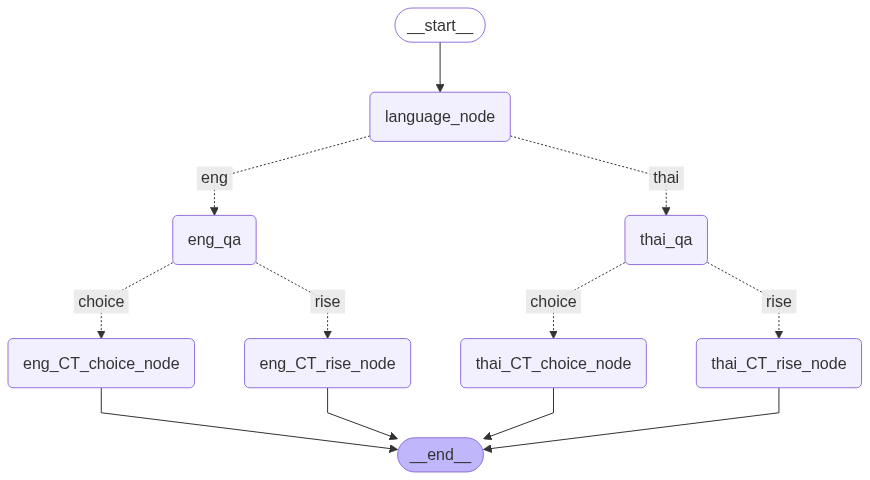

In [ ]:
from IPython.display import display, Image
try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass


### Asking you agent

In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
  inflating: data/english_context_sentences.csv  
  inflating: data/english_non_context_sentences.csv  
   creating: data/thai_context/
  inflating: data/thai_context/ae7107cc-6eee-482a-ae1a-5a454809640b.csv  
  inflating: data/thai_context/07d4daaf-9adc-48ed-ab6f-4f2f633ef2df.csv  
  inflating: data/thai_context/293dc56b-21d4-4db0-ba7c-263e56bdf7f3_candle.png  
  inflating: data/thai_context/3dc96b06-0c12-4d71-84b2-566bf519f7b0_candle.png  
  inflating: data/thai_context/c5ff368c-6852-461b-a437-92aa9dea33c8.csv  
  inflating: data/thai_context/b5536812-111a-45e8-9d93-e852bc9ba013.csv  
  inflating: data/thai_context/1685510f-f139-4b36-bafa-0c641e4f2411.csv  
  inflating: data/thai_context/e625dbc8-f448-4c53-9a78-6c3f351b49c3.csv  
  inflating: data/thai_context/dd570589-21de-48d3-9f3a-461396712ddd_candle.png  
  inflating: data/thai_context/417df0cd-10ee-4faa-abb3-9fa87e8b20db.csv  
  inflating: data/thai_context/f259d90e-7120-4459-a814-a

In [ ]:
df['id']

,id
0,e625dbc8-f448-4c53-9a78-6c3f351b49c3
1,9bea42e5-3c21-46dc-93f7-0017f382f7cf
2,a803daca-2cab-4d53-be68-c75fb71da84a
3,f101430b-bbe2-4803-a5ab-691e6295b1f9
4,f259d90e-7120-4459-a814-a456011fc840
...,...
45,a03e6249-f4e6-4c24-91ab-daa9f02bf9c9
46,29c5ad39-9344-4be0-bed6-5590131da2be
47,9ee0b342-46fd-49be-b001-411a98e0951e
48,7f79e8b5-5fbb-44dc-bb8b-2aa3c28126a3


In [ ]:
import tqdm

english = []
folder_path = '/content/data/english_context'

for file in tqdm.tqdm(os.listdir(folder_path)):
  if('.png' in file): english.append(file[:-4].replace('_candle',''))


thailand = []
folder_path = '/content/data/thai_context'

for file in tqdm.tqdm(os.listdir(folder_path)):
  if('.png' in file): thailand.append(file[:-4].replace('_candle',''))

thailand

100%|██████████| 102/102 [00:00<00:00, 717817.13it/s]


['4fc850d7-7c29-4ca3-9614-426e62364660',
 'a803daca-2cab-4d53-be68-c75fb71da84a',
 '6c9b6321-9d7a-4988-a0c3-a7c7fdb04def',
 'ed45ca23-3f20-4662-9dde-afcc3f20b0be',
 'f259d90e-7120-4459-a814-a456011fc840',
 '1685510f-f139-4b36-bafa-0c641e4f2411',
 '9bea42e5-3c21-46dc-93f7-0017f382f7cf',
 '3dc96b06-0c12-4d71-84b2-566bf519f7b0',
 '0257e1b2-4572-4ac8-8527-27d741f9f484',
 '417df0cd-10ee-4faa-abb3-9fa87e8b20db',
 'a70749e2-40b4-4316-be72-caf9c325493e',
 'dd570589-21de-48d3-9f3a-461396712ddd',
 'a6227157-d933-4185-b184-85d01b9de996',
 '467c2541-c4c6-479f-8fac-ddca1554d03a',
 'ed0074a8-aa7c-4499-8356-4720a17eb6fb',
 'ae7107cc-6eee-482a-ae1a-5a454809640b',
 'cab56075-c7ea-4456-9074-f734c41d44b9',
 'd0e16feb-4980-4212-86d6-7b54290fbd71',
 '4319211c-49f4-4af4-9ba8-0854ba3a8c1e',
 'cde3aba2-c5a4-47ec-835c-92f9b062c4af',
 '750940c9-5a1b-47cb-bf72-3bdabd156cda',
 'd9825631-a11e-463b-988f-4e070213f92b',
 'c5ff368c-6852-461b-a437-92aa9dea33c8',
 '468934ee-b596-4e39-b990-b16e4171fedc',
 'b5536812-111a-

In [ ]:
import pandas as pd

data_test= pd.read_csv("/content/test.csv")
data_test['id'][4]

'bcca13bc-2675-4645-82cc-7e4c412ed294'

In [ ]:
data_test['query'][0]

"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น อย่าใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม\n\nคำถาม: ______ สถานที่ทำงานเกี่ยวข้องกับการเสริมสร้างศักยภาพให้พนักงาน ตัวอย่างเช่น 'job enrichment' ที่พนักงานได้รับขอบเขตที่ใหญ่ขึ้นในการตัดสินใจว่าจะจัดระเบียบงานของตนอย่างไร หรือ 'job enlargement' ที่พนักงานได้รับมอบหมายงานที่หลากหลายมากขึ้น\n\nตัวเลือกคำตอบ: A: Re-invigorating, B: Re-flourishing, C: Revitalizing, D: Rehumanizing\n\nคำตอบ:"

In [ ]:
initial_state = {
      'id': data_test['id'][1],
      "messages": [HumanMessage(content=data_test['query'][1])],
      "agent_message": None,
      "answer": None,
      "thinking": None,
      "language": None,
      "qa_type" : None,
      "image": None
}
final_state = graph.invoke(initial_state)
print("Final Answer:", final_state["answer"])
print("Chain of Thought:", final_state["thinking"])
print("Agent Message:\n", final_state["agent_message"])
print("language:\n", final_state["language"])
print("qa_type:\n", final_state["qa_type"])


Final Answer: None
Chain of Thought: None
Agent Message:
 Based on the given question
language:
 eng
qa_type:
 choice


In [ ]:
ansewr=[]
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")
for idx, data in data_test.iterrows():
  if(data_test['id'][4] in english):
    initial_state = {
        # "csv": None,
        'id': data_test['id'][4],
        "messages": [HumanMessage(content=data_test['query'][idx])],
        "agent_message": None,
        "answer": None,
        "thinking": None,
        "language": "eng",
        "qa_type" : None,
        "image": encode_image('/content/data/english_context/'+data_test['id'][4]+'_candle.png')
    }
    final = graph.invoke(initial_state)
  elif(data_test['id'][4] in thailand):
    initial_state = {
        # "csv": None,
        'id': data_test['id'][idx],
        "messages": [HumanMessage(content=data_test['query'][idx])],
        "agent_message": None,
        "answer": None,
        "thinking": None,
        "language": "thai",
        "qa_type" : None,
        "image": encode_image('/content/data/thai_context/'+data_test['id'][4]+'_candle.png')
    }
  else:
    initial_state = {
      # "csv": None,
      'id': data_test['id'][idx],
      "messages": [HumanMessage(content=data_test['query'][idx])],
      "agent_message": None,
      "answer": None,
      "thinking": None,
      "language": None,
      "qa_type" : None,
      "image": None
  }
  final_state = graph.invoke(initial_state)
  answer.append(final_state['answer'])

In [ ]:
sub = pd.DataFrame({"id": data_test['id'], "answer": answer})
sub.to_csv("submission.csv", index=False)